# Left Ventricle Full Quantification (LVQuan18) Challenge MICCAI 2018


Accurate cardiac left ventricle (LV) quantification is among the most clinically important and most frequently demanded tasks for identification and diagnosis of cardiac diseases and is of great interest in the research community of medical image analysis.
To explain what the challenge is about in the context of machine learning, I use the approach explained here:
https://machinelearningmastery.com/how-to-define-your-machine-learning-problem/.

It involves answering three questions:

### Problem description

In one sentence, we want a system that will find some information about the Left Ventricle (LV) out of cardiac images
to diagnose some heart diseases.

Tom Mitchell’s definition of a machine learning problem requires the definition of Tasks,
Experience and Performance. These terms are defined for this problem as follows:

* Tasks: Compute LV indices of each slice of patient cardiac SAX MR images. These indices are:

    1. Areas of LV cavity and myocardium : $A_{1}$ and $A_{2}$ (see Fig.1(a))
    2. Dimensions of LV cavity: $D_{1}, D_{2}$ and $D_{3}$ (see Fig.1(b))
    3. Reginal Wall Thickness of myocardium: $RWT_{1}, ..., RWT_{6}$ (see Fig.1(c))
    4. Cardiac phase (when images are acquired): diastole (0) or systole(1) (see Fig.1(d))
   
   <figure>
  <img src="data/lvquan.jpg" width="600">
  <figcaption> <center> Figure 1. LV indices to find. Orange and green areas are respectively LV cavity and myocardium.
  </center> </figcaption>
</figure>
   
    
* Experiences: A set of 145 anonymized patient cardiac SAX MR images with all 4 indices for each slice.


* Performance: Mean Absolute Error (MAE) to assess the performance of the method for estimation of indices 1,2 and 3. For the last indice, the Error Rate of the misclassified cardiac phase is used. Their formulae are:


$ MAE_{indice} = \frac{\sum_{i=1}^{N} \lvert Pred^{indice}_{i}  -  GT^{indice}_{i} \rvert }{N} $

$ER_{phase} = \frac{\sum_{i=1}^{N} Cardinal(Pred^{phase}_{i} \neq GT^{phase}_{i}) }{N} $

### The dataset provided

A training dataset with processed SAX MR sequences of 145 subjects from clinical environment is used for model learning and validation.

For each subject, 20 frames are included for the whole cardiac cycle. All ground truth values of the above-mentioned LV indices are provided for every single frame. More details about the training dataset can be found in the document of the DIG-Cardiac dataset. 


A complete information of the challenge can be found at: https://lvquan18.github.io/

References: 

[1]: Figure 1 from https://lvquan18.github.io/2018/03/12/objective.html

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
%matplotlib inline
%reload_ext autoreload
%autoreload 2

PATH ='data/'

## Dataset exploration

The provided dataset is a matlab file (.mat). 

Thus we're going to use scipy.io which can open this kind of file in python.

In [2]:
import scipy.io as sio

data = sio.loadmat(PATH+'cardiac-dig.mat')
data.keys()


dict_keys(['__header__', '__version__', '__globals__', 'areas', 'dims', 'endo_LV', 'epi_LV', 'images_LV', 'lv_phase', 'pix_spa', 'ratio_resize_inverse', 'rwt'])

In [4]:
f'{data["images_LV"].shape}, 2900 / 20 frames =  {2900/20} patients'

'(80, 80, 2900), 2900 / 20 frames =  145.0 patients'

In [5]:
n_diastolic = np.sum(data["lv_phase"] == 0) // 20
n_systolic = np.sum(data["lv_phase"] == 1) // 20
print(f'Number of sequences in diastolic phase :  {n_diastolic}')
print(f'Number of sequences in systolic phase  :  {n_systolic}')
print(f'Total                                  : {n_diastolic + n_systolic}')


Number of sequences in diastolic phase :  84
Number of sequences in systolic phase  :  61
Total                                  : 145


### An analysis of the relation between LV cavity area and the phase

[0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1]
[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]


Text(0,0.5,'Area of LV cavity')

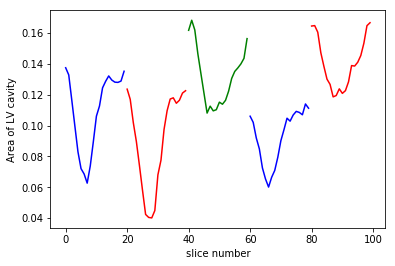

In [6]:
S = 20
k = 5
A = 0
for i in range(k):
    print(data['lv_phase'][0,i*S:(i+1)*S])
    
plt.plot(data['areas'][A,:S], 'b', range(S, 2*S), data['areas'][A,S:S+S], 'r',
        range(2*S, 3*S), data['areas'][A,2*S:3*S], 'g', 
        range(3*S, 4*S), data['areas'][A,3*S:4*S], 'b',
        range(4*S, 5*S), data['areas'][A,4*S:5*S], 'r')
plt.xlabel('slice number')
plt.ylabel('Area of LV cavity')

**Remark:**

It appears from the plot above that when the LV cavity area decreases, the phase is 1: Systole.

And, it equals 0 (diastole) when LV cavity increases. So one way to find the phase is to track
the LV cavity area

In [7]:
patient = data['images_LV'][:,:,:20]
seg_endo = data['endo_LV'][:,:,:20]
seg_epi = data['epi_LV'][:,:,:20]

def get_sample(seq, size=3):
    return np.hstack([seq[:,:,i] for i in range(size)])

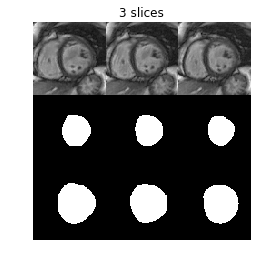

In [8]:
n = 3
slice_sample = get_sample(patient, n)
seg_endo_sample = get_sample(seg_endo, n)
seg_epi_sample = get_sample(seg_epi, n)
samples = np.vstack((slice_sample, seg_endo_sample, seg_epi_sample))
plt.imshow(samples, cmap='gray')
plt.title(f'{n} slices')
plt.axis("off")
plt.show()


In [9]:
print ('dims attribute', data['dims'].shape, data['dims'][:,0])
print ('areas attribute', data['areas'].shape, data['areas'][:,0])
print ('rwt attribute', data['rwt'].shape, data['rwt'][:,0])

dims attribute (3, 2900) [ 0.40795  0.4411   0.40617]
areas attribute (2, 2900) [ 0.13742  0.09059]
rwt attribute (6, 2900) [ 0.06005  0.04753  0.05253  0.05125  0.04902  0.06165]


# Our approach

We're going to directly predict LV indices from images without segmentation.

For that we use a classical model (e.g resnet50) for a regression task where the output
vector will contain all these values:
1. Areas: 2 values
2. Dimensions: 3 values
3. Reginal Wall Thickness: 6 values

Thus, an output vector of 11 values.

For the cardiac phase, we plan to use direct algorithm, no machine learning,
that will track LV area (A1) across slices and use the remark done above
to find the cardiac phase.


In [10]:
def show_min_max(feats, name):
    print(f'min')
    
min_max = {}
for k in ['areas', 'dims', 'rwt']:
    l = data[k].shape[0]
    for i in range(l):
        min_max[k+'_'+str(i+1)] = [np.min(data[k][i,:]), np.max(data[k][i,:]), np.mean(data[k][i,:])]

In [11]:
df = pd.DataFrame(min_max).transpose()
print(df)
df.to_csv("LV_indices_sumup.csv",  header=[ 'min', 'max', 'mean'])

                0         1         2
areas_1  0.028125  0.206016  0.122527
areas_2  0.049023  0.245039  0.115107
dims_1   0.188220  0.509289  0.377495
dims_2   0.195758  0.540953  0.402957
dims_3   0.173934  0.556315  0.392373
rwt_1    0.021334  0.198047  0.085638
rwt_2    0.010757  0.170242  0.065623
rwt_3    0.016626  0.173010  0.064851
rwt_4    0.019094  0.167630  0.066266
rwt_5    0.018727  0.179142  0.064009
rwt_6    0.024604  0.209354  0.080259


In [12]:
infos = pd.read_csv('LV_indices_sumup.csv', )
infos

,Unnamed: 0,min,max,mean
0,areas_1,0.028125,0.206016,0.122527
1,areas_2,0.049023,0.245039,0.115107
2,dims_1,0.188220,0.509289,0.377495
3,dims_2,0.195758,0.540953,0.402957
4,dims_3,0.173934,0.556315,0.392373
5,rwt_1,0.021334,0.198047,0.085638
6,rwt_2,0.010757,0.170242,0.065623
7,rwt_3,0.016626,0.173010,0.064851
8,rwt_4,0.019094,0.167630,0.066266
9,rwt_5,0.018727,0.179142,0.064009


In [7]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
# torch.cuda.set_device(3)

### Format input/output for CNN

Make one-channel input to 3 channel.
Arrange input/output axis for fastai.

(2900, 11)
(2900, 80, 80, 3)


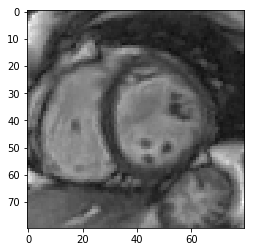

In [3]:
tmp_x = np.moveaxis(data['images_LV'], -1, 0)
x = np.empty((2900, 80, 80, 3))
for i in range(x.shape[0]):
    x[i] = np.stack((tmp_x[i],)*3, -1)

y = np.concatenate((data['areas'],data['dims'], data['rwt'])).T
print(y.shape)
print(x.shape)
plt.imshow(x[0])

In [4]:
def patientToImgIdx(patient_idxs):
    image_idxs = []
    for i in patient_idxs:
        image_idxs.append(np.arange(i*20, (i+1)*20))
    return np.concatenate(image_idxs)

def n_folds_split(n_samples, folds=3, seed=42):
  # reproducible results with a fixed seed
    rng = np.random.RandomState(seed)
    indices = np.arange(n_samples)
    rng.shuffle(indices)
    spf, r = np.divmod(n_samples, folds)
    rr = [0]
    if r!= 0:
        rr += [i*(spf+1)for i in range(1, r+1)]
        rr += [i for i in range(rr[-1]+spf, n_samples+1, spf)]
    else: 
        rr += [i*spf for i in range(1, folds+1)]
    
    splits = [indices[rr[i]:rr[i+1]] for i in range(folds)]
    cv_splits = [(splits[i], np.concatenate([s for s in splits if s is not splits[i]])) for i in range(folds)]
    return cv_splits


folds = n_folds_split(145, 5)


## First fold of 5-CV folds

In [6]:
# trn, val, test
val, trn = folds[0]
print(f'val shape: {val.shape}\ntrn: {trn.shape}')
val = patientToImgIdx(val)
trn = patientToImgIdx(trn)
print(f'val shape: {val.shape}\ntrn: {trn.shape}')
dtrn = (x[trn], y[trn])
dval = (x[val], y[val])
# dtest = (x[test], y[test])
darray = (dtrn, dval, None)

val shape: (29,)
trn: (116,)
val shape: (580,)
trn: (2320,)


In [7]:
def get_data(darray, arch, bs, aug=transforms_top_down):
    tfms = tfms_from_model(arch, sz=80, aug_tfms=aug, crop_type=CropType.NO)
    trn, val, test = darray
    data = ImageClassifierData.from_arrays(PATH, trn, val, bs, tfms, test=test, continuous=True)
    return data

arch = resnext50
bs=20
md = get_data(darray, arch, bs, aug=transforms_top_down)
md.is_reg()


True

In [18]:
head_reg11 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(18432, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(0.4),
    nn.Linear(1024,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.25),
    nn.Linear(256, 11))
# head_reg11 = nn.Sequential(Flatten())
learner = ConvLearner.pretrained(arch, md, custom_head=head_reg11)
learner.opt_fn = optim.Adam
learner.crit = nn.L1Loss()

In [52]:
learner.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 80, 80]),
                           ('output_shape', [-1, 64, 40, 40]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 40, 40]),
                           ('output_shape', [-1, 64, 40, 40]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 40, 40]),
                           ('output_shape', [-1, 64, 40, 40]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 40, 40]),
                           ('output_shape', [-1, 64, 20, 20]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 20, 20]),
        

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 72%|███████▏  | 83/116 [00:04<00:01, 16.80it/s, loss=1.07] 


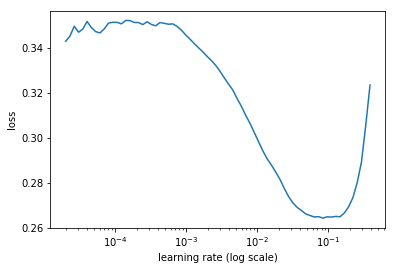

In [19]:
learner.lr_find(1e-5,100)
learner.sched.plot(5)

In [20]:
lr = 1e-2
lr

0.01

In [21]:
learner.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.072041   0.033682  
    1      0.041053   0.02969                                 
    2      0.030518   0.029565                                



[array([ 0.02957])]

In [ ]:
learner.load('rnx50_cv1_ft_0.029')

In [23]:
learner.fit(lr, 2, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.02537    0.026807  
    1      0.021341   0.023306                                
    2      0.022888   0.024292                                
    3      0.020526   0.023286                                



[array([ 0.02329])]

In [24]:
predictions, target = learner.predict_with_targs()

In [29]:
learner.load('rnx50_cv1_ft_0.023')

In [28]:
i = 2
predictions[i], target[i]

(array([ 0.13577,  0.11509,  0.39784,  0.42617,  0.40632,  0.08704,  0.06483,  0.0618 ,  0.06358,  0.05727,
         0.07556], dtype=float32),
 array([ 0.10824,  0.10371,  0.33833,  0.38451,  0.38869,  0.08352,  0.06874,  0.06747,  0.07309,  0.04978,
         0.06258], dtype=float32))

In [31]:
lrs = np.array([lr/100,lr/10,lr])
learner.freeze_to(-2)

In [32]:
learner.fit(lrs, 3, cycle_len=2, cycle_mult=2, best_save_name='rnx50_cv1')

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.0224     0.163618  
    1      0.018282   0.017414                                
    2      0.019788   0.022512                                
    3      0.017675   0.017144                                
    4      0.0156     0.018585                                
    5      0.01392    0.018101                                
    6      0.018888   0.067931                                
    7      0.018096   0.022949                                
    8      0.01618    0.018208                                
    9      0.015325   0.01556                                 
    10     0.014464   0.01434                                 
    11     0.013495   0.013887                                
    12     0.013555   0.014008                                
    13     0.013038   0.013861                                



[array([ 0.01386])]

In [39]:
predictions, target = learner.predict_with_targs()

In [36]:
i = 10
predictions[i], target[i]

(array([ 0.10384,  0.09974,  0.35204,  0.37524,  0.36009,  0.07747,  0.06227,  0.06047,  0.05997,  0.05828,
         0.07352], dtype=float32),
 array([ 0.09555,  0.09922,  0.31873,  0.35904,  0.36678,  0.08878,  0.0649 ,  0.06406,  0.06571,  0.05224,
         0.07155], dtype=float32))

In [44]:
learner.load('rnx50_cv1_lgp2_0.138')

In [45]:
learner.freeze_to(-3)
learner.fit(lrs, 5, cycle_len=2, cycle_mult=2, best_save_name='rnx50_cv1')

HBox(children=(IntProgress(value=0, description='Epoch', max=62), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.018278   0.046808  
    1      0.014877   0.014682                                
    2      0.018419   0.143103                                
    3      0.016661   0.015078                                
    4      0.014615   0.013977                                
    5      0.013678   0.014282                                
    6      0.017835   0.027047                                
    7      0.019898   1.088849                                
    8      0.020078   0.974358                                
    9      0.017521   0.033775                                
    10     0.015706   0.01768                                 
    11     0.014527   0.072801                                
    12     0.013734   0.018343                                
    13     0.013648   0.07079                                 
    14     0.020717   0.020786                                
    15     0.019278   

[array([ 0.0142])]

In [49]:
learner.load('rnx50_cv1')
predictions, target = learner.predict_with_targs()
F.l1_loss(Variable(torch.from_numpy(predictions)), Variable(torch.from_numpy(target))).data[0]

0.012532822787761688

## Custom loss: LogCosh loss

module

In [115]:
class LogCosh_Loss(torch.autograd.Function):

    def __init__(self):
        super(LogCosh_Loss, self).__init__()

    def forward(self,input, target):
        output = torch.log(torch.cosh(input - target))
        output = torch.sum(output)
        output = torch.Tensor([output]).cuda() # NEW line
#         input = torch.Tensor([input]).cuda()
        self.save_for_backward(input, output)
        return output
    


In [116]:
input = Variable(torch.rand(3))
target = Variable(torch.rand(3))
loss = torch.sum(torch.log(torch.cosh(input - target)))
LogCosh_Loss()(input, target)

Variable containing:
 0.1081
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [117]:
input.data


 0.1104
 0.1924
 0.4644
[torch.FloatTensor of size 3]

In [118]:
input = Variable(torch.rand(3))
target = Variable(torch.rand(3))
save = True
res = torch.autograd.gradcheck(LogCosh_Loss(), (input, target), raise_exception=False)
print(res) # res should be True if the gradients are correct.

True


## Visualization of endocardium and epicardium

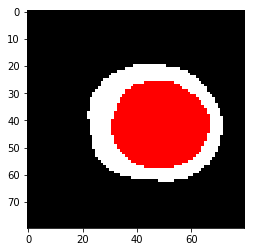

In [167]:
red  = (255, 0, 0) #np.array([255, 0, 0], dtype=np.uint8)
green = (0, 255, 0) #np.array([0, 255, 0], dtype=np.uint8)
blue   = (0, 0, 255) 
def overlay(im, mask, color):
    overlaid = im.copy()
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if (mask[i,j] > 100).all():
                overlaid[i,j] = color
    return overlaid

pat_endo = data['endo_LV'][:,:,200]
pat_endo = make_cv2_compatible(pat_endo)
pat_epi = data['epi_LV'][:,:,200]
pat_epi = make_cv2_compatible(pat_epi)
both = overlay(pat_epi, pat_endo, red)
plt.imshow(both)



## Compute Bounding Boxes of endocardium and epicardium segments

(80, 80, 3)
1
(22, 20, 50, 43)


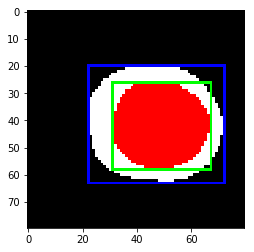

In [169]:
import cv2

def make_cv2_compatible(img, cmap='gray'):
    plt.imsave("tmp.jpg", img, cmap=cmap )
    im = cv2.imread('tmp.jpg')
    return im

def min_max(x):
    return np.min(x), np.max(x)


def meth1(pat):
    xs, ys = np.where(pat==1)
    min_x, max_x = min_max(xs)
    min_y, max_y = min_max(ys)
    # points = [[xs[i], ys[i]] for i in [min_x, max_x, min_y, max_y]]
    points = np.array([[min_y,min_x], [max_y,max_x]])
    return  cv2.boundingRect(points)
 
def get_bb(pat):
    im = make_cv2_compatible(pat)
    ctrs= cv2.findContours( cv2.cvtColor(im, cv2.COLOR_BGR2GRAY),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE )[1]
    return cv2.boundingRect(ctrs[0])
    
pat = data['epi_LV'][:,:,200]




xs, ys = np.where(pat==1)

min_x, max_x = min_max(xs)
min_y, max_y = min_max(ys)
# points = [[xs[i], ys[i]] for i in [min_x, max_x, min_y, max_y]]
points = np.array([[min_y,min_x], [max_y,max_x]])
# seg_endo[:,:,0][22,39]
pat = make_cv2_compatible(pat)
print(pat.shape)
ctrs= cv2.findContours( cv2.cvtColor(pat, cv2.COLOR_BGR2GRAY),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE )[1]
print(len(ctrs))
(x, y, w, h) = cv2.boundingRect(points)
print((x, y, w, h))
cv2.rectangle(both,(x, y), (x + w, y + h), (0, 0, 255), 1)
plt.imshow(both)

In [158]:
n = data["images_LV"].shape[-1]
print(data['endo_LV'].shape,n)
endo_bb = [meth1(data['endo_LV'][:,:,i]) for i in range(n)]
epi_bb = [meth1(data['epi_LV'][:,:,i]) for i in range(n)]

(80, 80, 2900) 2900
